https://colab.research.google.com/github/JunetaeKim/GCSP-HBDA/blob/main/Week2/Lecture1.3.ipynb

### Topic: Processing and Merging TCGA Data
##### Goals: Processing and merging TCGA (The Cancer Genome Atlas) data. 
##### We'll practice through each step, from importing necessary libraries to saving the final merged dataset.

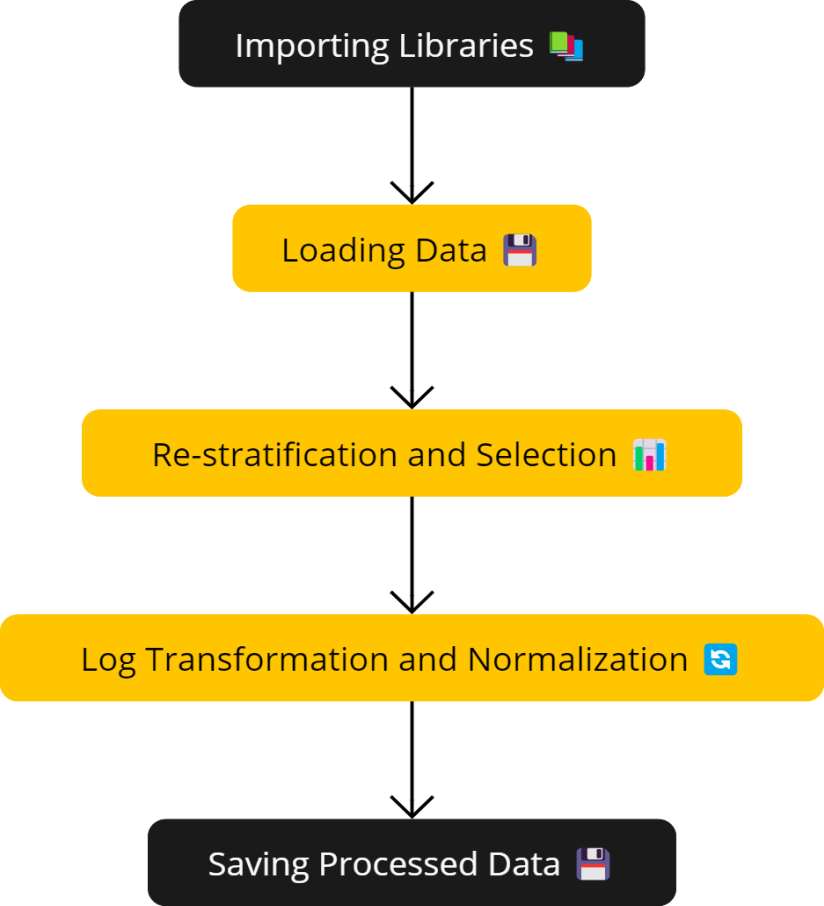

#### 1. Importing Libraries 📚
##### Objective: Load the necessary Python libraries for data processing.

In [1]:
import pandas as pd  # Essential for data manipulation and analysis
import numpy as np  # Useful for numerical operations
import pickle  # Enables object serialization for saving and loading
import matplotlib.pyplot as plt  # Key for data visualization

#### Explanation: 
##### pandas and numpy are crucial for handling and processing data efficiently.
##### pickle is used for loading and saving Python objects.
##### matplotlib is used to create visualizations of the data distributions.

#### 2. Loading Data 💾
##### Objective: Load the necessary Python libraries for data processing.

In [2]:
with open('./SourceData/rsubread/complete_data_merged.pickle', 'rb') as f:
    TotalData = pickle.load(f)  # Load the dataset

#### Explanation:
##### pandas and numpy are crucial for handling and processing data efficiently.
##### We use the pickle library to load the data from a serialized file.
##### The data is stored in a variable called TotalData.

#### 3. Re-stratification and Selection 📊
##### Objective: Filter and re-stratify data based on tumor types and races with sufficient counts.
##### 3.1 Filter Data Based on Counts

In [3]:
# Get unique tumor types and their counts
tum, count = np.unique(TotalData['tumor_type'], return_counts=True)
# Select tumor types with counts greater than 200
TUMOR_TYPE = tum[count > 200]

# Get unique races and their counts
race, count = np.unique(TotalData['race'], return_counts=True)
# Select races with counts greater than 200
RACE_TYPE = race[count > 200]

# Filter TotalData to include only selected tumor types and races
TotalData = TotalData[TotalData['tumor_type'].isin(TUMOR_TYPE)].copy()
TotalData = TotalData[TotalData['race'].isin(RACE_TYPE)].copy()

#### Explanation:
##### We filter the dataset to include only tumor types and races with counts greater than 200.
##### This ensures that we have sufficient data for each category for meaningful analysis.

##### 3.2 Define Columns

In [4]:
# Extract all column names
Columns = TotalData.columns.tolist()

# Define metadata columns
MetaCol = ['patient_id', 'time', 'event']
# Define demographic binary and continuous columns
DemoBinCont = ['gender', 'age']
# Define demographic categorical columns
DemoCate = ['race', 'tumor_type']
# Combine all demographic columns
DemoCol = DemoBinCont + DemoCate
# Identify gene expression columns by excluding metadata and demographic columns
GeneCol = list(set(Columns) - set(MetaCol) - set(DemoCol))
GeneCol.sort()

#### Explanation:
##### Columns are classified into metadata, demographic, and gene expression columns for easier handling and processing.

##### 3.3 Remove Low Variance Genes

In [5]:
# Calculate variance for each gene expression column
RemCheckVar = TotalData.loc[:, GeneCol].var()

# Identify genes with variance below the 95th percentile
RemList = RemCheckVar[RemCheckVar < RemCheckVar.quantile(0.95)].index.to_list()
# Remove low variance genes from the dataset
TotalData = TotalData.drop(columns=RemList)

# Update GeneCol to reflect removed genes
Columns = TotalData.columns.tolist()
GeneCol = list(set(Columns) - set(MetaCol) - set(DemoCol))
GeneCol.sort()
print(len(RemCheckVar) - len(RemList))  # Output number of removed genes

1169


#### Explanation:
##### Genes with low variance (below the 95th percentile) are removed to reduce noise and computational load.
##### This step helps in focusing on more significant gene expressions.

##### 3.4 Plot Unique Value Distributions

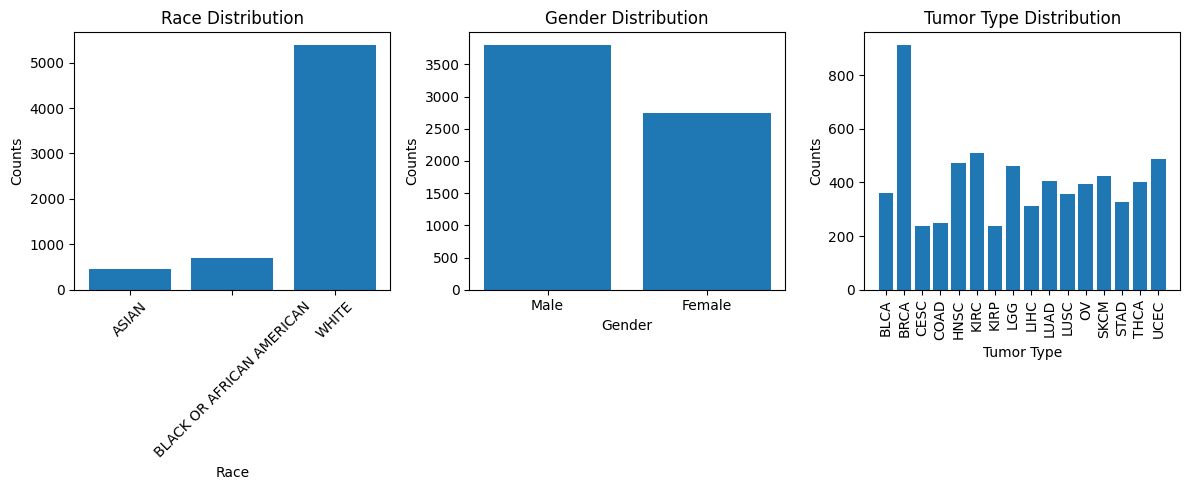

In [6]:
def plot_unique_value_distribution(data, column_name, ax, title, x_label, x_tick_labels=None, rotation=0):
    """
    Plots the distribution of unique values for a given column.
    
    Parameters:
    - data: The dataset.
    - column_name: The column to plot.
    - ax: The matplotlib axes to plot on.
    - title: The plot title.
    - x_label: The x-axis label.
    - x_tick_labels: Custom labels for the x-ticks.
    - rotation: Rotation angle for x-tick labels.
    """
    unique_values, counts = np.unique(data[column_name], return_counts=True)
    ax.bar(unique_values, counts)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Counts')
    if x_tick_labels:
        ax.set_xticks(unique_values)
        ax.set_xticklabels(x_tick_labels)
    ax.tick_params(axis='x', rotation=rotation)

# Create subplots to display distributions
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Plot race distribution
plot_unique_value_distribution(TotalData, 'race', axs[0], 'Race Distribution', 'Race', rotation=45)
# Plot gender distribution
plot_unique_value_distribution(TotalData, 'gender', axs[1], 'Gender Distribution', 'Gender', ['Male', 'Female'])
# Plot tumor type distribution
plot_unique_value_distribution(TotalData, 'tumor_type', axs[2], 'Tumor Type Distribution', 'Tumor Type', rotation=90)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

#### Explanation:
##### A function is defined to plot the distribution of unique values for specified columns.
#####  Subplots are created to visualize the distributions of race, gender, and tumor types.

#### 4. Log Transformation and Normalization 🔄
##### Objective: Apply log transformation and normalize data for analysis.
##### 4.1 Log Transformation

In [7]:
# Apply log2 transformation to gene expression data
LogTotalData = pd.DataFrame(np.log2(TotalData.loc[:, GeneCol].values + 1), columns=TotalData.loc[:, GeneCol].columns)
# Combine transformed gene expression data with metadata and demographic data
LogTotalData = pd.concat([TotalData.loc[:, MetaCol + DemoCol].reset_index(drop=True), LogTotalData], axis=1)
# Ensure correct data types for 'event' and 'gender' columns
LogTotalData['event'] = LogTotalData['event'].astype(np.float32)
LogTotalData['gender'] = LogTotalData['gender'].astype(np.float32)

#### Explanation:
##### Log2 transformation is applied to gene expression data to stabilize variance and make data more normal distribution-like.
##### The transformed gene expression data is combined with metadata and demographic data.

##### 4.2 Normalization

In [8]:
# Copy the log-transformed data for normalization
AnalData = LogTotalData.copy()
# Calculate minimum values for normalization
Min = AnalData.loc[:, GeneCol + DemoBinCont].min()
# Calculate maximum values for normalization
Max = AnalData.loc[:, GeneCol + DemoBinCont].max()
# Apply min-max normalization to scale data between 0 and 1
AnalData.loc[:, GeneCol + DemoBinCont] = (AnalData.loc[:, GeneCol + DemoBinCont] - Min) / (Max - Min)

#### Explanation:
##### Min-max normalization is applied to gene expression and continuous demographic data to scale values between 0 and 1.
##### This step ensures that all data are on a comparable scale.

#### 5. Saving Processed Data 💾
##### Objective: Save the processed and normalized data for further analysis.

In [9]:
#AnalData.to_csv('./ProcessedData/AnalData.csv', index=False)  # Save the data to a CSV file

#### Explanation:
##### The processed and normalized data is saved to a CSV file, making it ready for subsequent analysis and modeling.

#### Summary
##### Importing Libraries: Load necessary Python libraries for data manipulation, numerical operations, serialization, and visualization.
##### Loading Data: Load the dataset from a pickle file.
##### Re-stratification and Selection: Filter data to include only relevant tumor types and races, remove low variance genes, and visualize data distributions.
##### Log Transformation and Normalization: Apply log transformation to gene expression data and normalize values for analysis.
##### Saving Processed Data: Save the cleaned and processed data to a CSV file for further use.